In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import gc
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
stop_words = set(stopwords.words('russian'))

pd.set_option('display.max_colwidth', None)

In [2]:

dtype_dict = {
    'Unnamed: 0': 'int32',
    'id': 'str',
    'date': 'str',
    'views': 'float32',
    'reactions': 'str',
    'to_id': 'str', 
    'fwd_from': 'str',
    'message': 'str',
    'type': 'category', 
    'duration': 'float32',
    'dialog_id': 'str',
    'frw_from_title': 'str', 
    'frw_from_name': 'str',
    'msg_entity': 'str'
}

chunk_size = 10000 
chunks = pd.read_csv('./merged_data.csv', chunksize=chunk_size, dtype=dtype_dict)

df = pd.concat(chunks, ignore_index=True)

print(df.head())

   Unnamed: 0       id                       date   views  \
0           0  12602.0  2022-12-19 13:05:23+00:00  3645.0   
1           1  12601.0  2022-12-19 09:52:21+00:00  5831.0   
2           2  12600.0  2022-12-19 09:18:53+00:00  3944.0   
3           3  12599.0  2022-12-19 08:32:39+00:00  2970.0   
4           4  12598.0  2022-12-18 21:41:25+00:00  4993.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                reactions  \
0                                                                                                                           

## Check if spike exist

2371994400.0


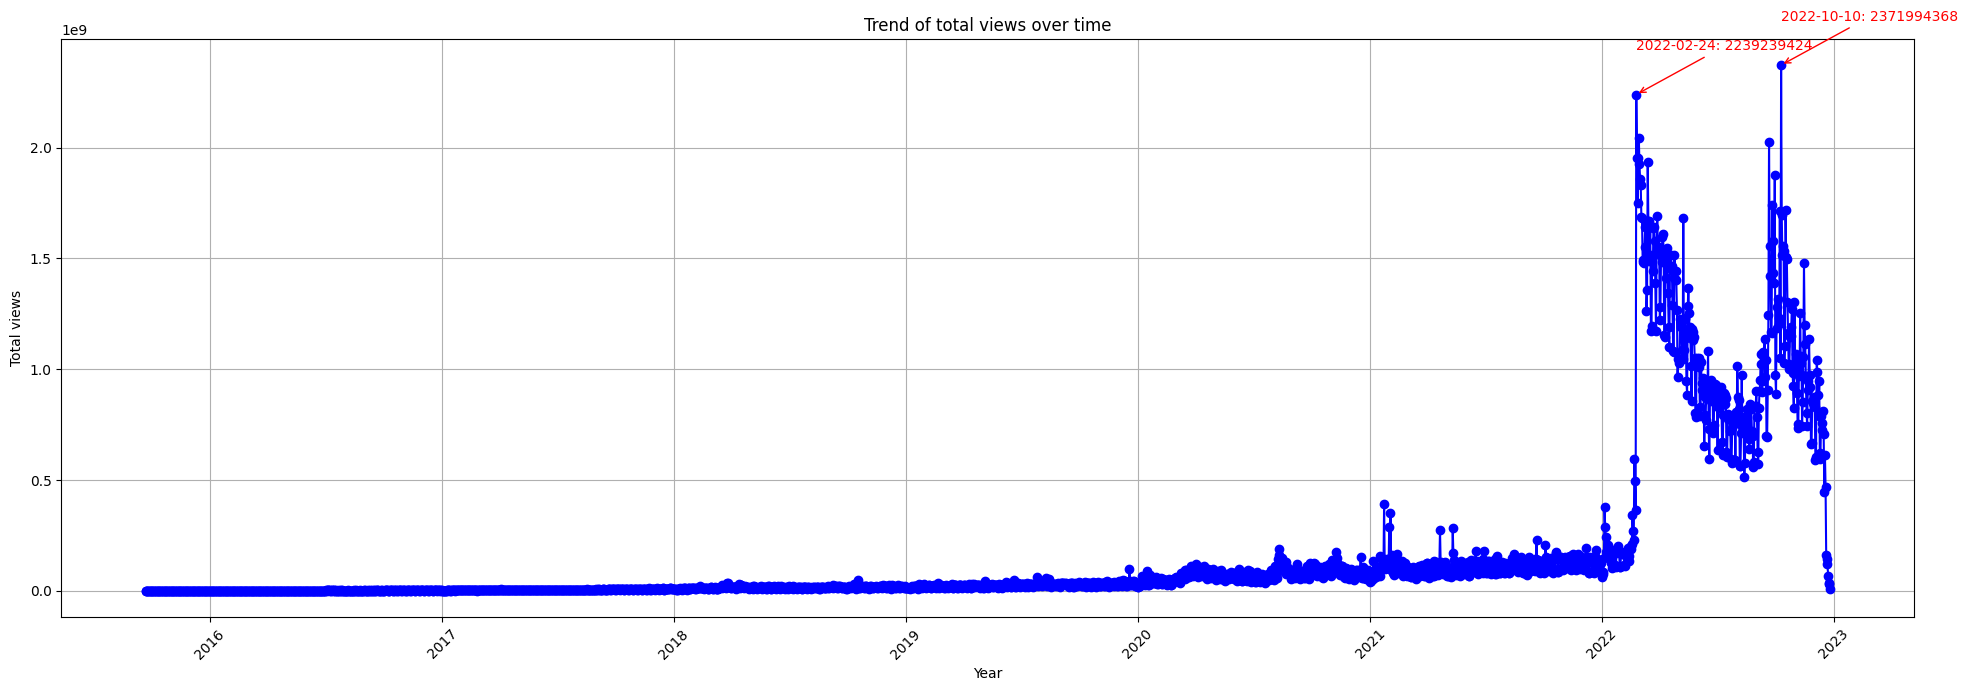

In [4]:
df['date'] = pd.to_datetime(df['date'])

views_per_day = df.groupby(df['date'].dt.date)['views'].sum()
print(views_per_day.max())

plt.figure(figsize=(20, 7)) # added in 5 HW
plt.plot(views_per_day.index, views_per_day.values, marker='o', linestyle='-', color='b')
plt.title('Trend of total views over time')
plt.xlabel('Year')
plt.ylabel('Total views')
plt.grid(True)
plt.xticks(rotation=45)

for date, views in views_per_day.items():
    if views > 2100000000:
        plt.annotate(
            f"{date}: {int(views)}",
            xy=(date, views),
            xytext=(date, views + 200000000),
            arrowprops=dict(arrowstyle="->", color='red'),
            fontsize=10,
            color='red'
        )

plt.tight_layout()
plt.show()

## 1. Top 5 channels with the highest percentage of positive/negative reactions

In [7]:
other_reactions = ['🤯', '🤔', '🙏', '😂']
positive_reactions = ['👍', '🔥', '👏', '😁', '❤️', '💯', '🌚', '❤', '🥰', '🎉']
negative_reactions = ['👎', '😢', '🤮', '🤡', '🤬', '💩', '😱']

def count_positive_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return 0

    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    count = 0
    for emoji, num in matches:
        if emoji in positive_reactions:
            count += int(num)
    return count
   
def count_negative_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return 0

    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    count = 0
    for emoji, num in matches:
        if emoji in negative_reactions:
            count += int(num)
    return count

# Перевірка, чи канал взагалі має негативні реакції. Якщо немає - скоріш за все сам адміністратор каналу вимкнув таку можливість, тож сенсу перевіряти такі канали немає.
def has_negative_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return False
    
    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    for emoji, num in matches:
        if emoji in negative_reactions:
            return True
    return False

df['has_negative_reactions'] = df['reactions'].apply(has_negative_reactions)
channels_with_negative_reactions = df[df['has_negative_reactions'] == True]

df['positive_reactions_count'] = df['reactions'].apply(count_positive_reactions)
df['negative_reactions_count'] = df['reactions'].apply(count_negative_reactions)

df['total_reactions_count'] = df['positive_reactions_count'] + df['negative_reactions_count']

channel_reactions = channels_with_negative_reactions.groupby('dialog_id').agg({
    'positive_reactions_count': 'sum',
    'negative_reactions_count': 'sum',
    'total_reactions_count': 'sum'
})

channel_reactions['positive_reactions_percentage'] = (channel_reactions['positive_reactions_count'] / channel_reactions['total_reactions_count']) * 100
channel_reactions['negative_reactions_percentage'] = (channel_reactions['negative_reactions_count'] / channel_reactions['total_reactions_count']) * 100

channel_reactions = channel_reactions[channel_reactions['total_reactions_count'] > 1000]

top_positive_channels = channel_reactions.sort_values(by='positive_reactions_percentage', ascending=False).head(5)
top_negative_channels = channel_reactions.sort_values(by='negative_reactions_percentage', ascending=False).head(5)

print("Top 5 channels with the highest percentage of positive reactions:")
print(top_positive_channels[['positive_reactions_percentage']])

print("\nTop 5 channels with the highest percentage of negative reactions:")
print(top_negative_channels[['negative_reactions_percentage']])


Top 5 channels with the highest percentage of positive reactions:
                 positive_reactions_percentage
dialog_id                                     
zhogaartem                           98.401142
mkhusnullin                          97.089549
govoritfursov                        97.085428
razvedkavperedZ                      96.859219
RKadyrov_95                          96.718930

Top 5 channels with the highest percentage of negative reactions:
                   negative_reactions_percentage
dialog_id                                       
achexd2                                84.656675
sotaproject                            65.748608
varlamov_news                          64.252010
rasstriga                              61.425765
redakciya_channel                      57.685183


## 5 HW version:

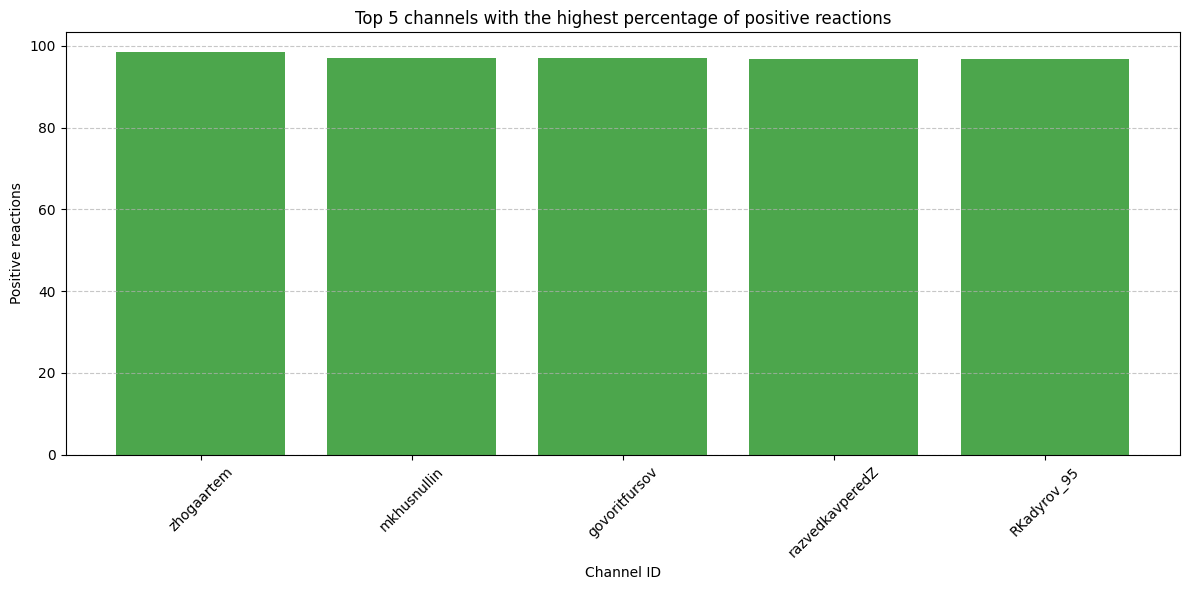

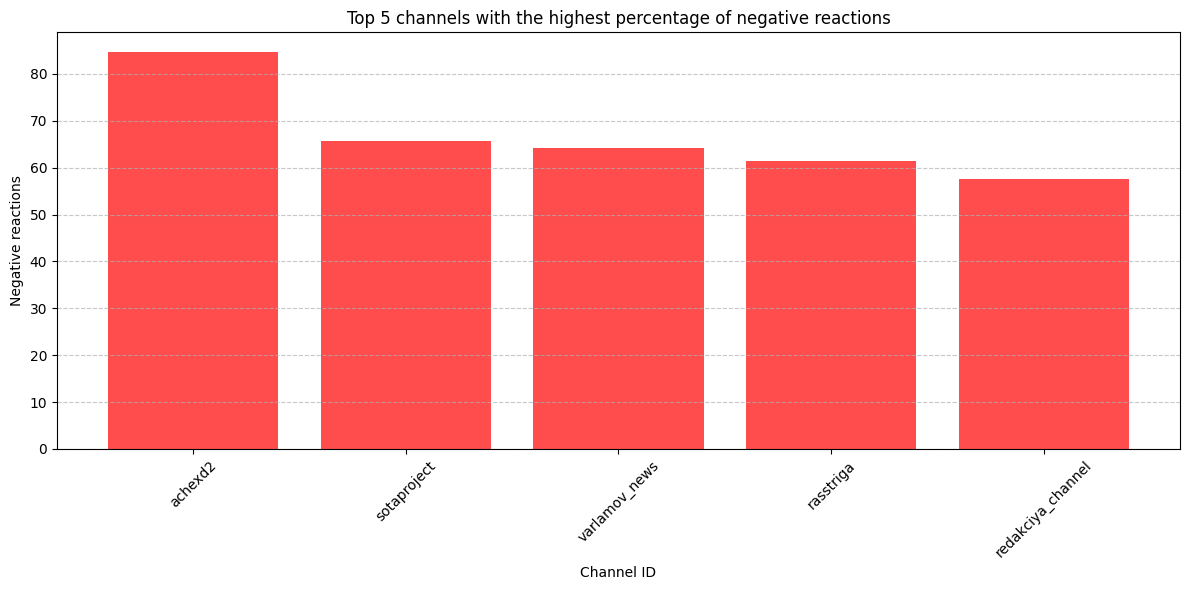

In [12]:
other_reactions = ['🤯', '🤔', '🙏', '😂']
positive_reactions = ['👍', '🔥', '👏', '😁', '❤️', '💯', '🌚', '❤', '🥰', '🎉']
negative_reactions = ['👎', '😢', '🤮', '🤡', '🤬', '💩', '😱']

def count_positive_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return 0

    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    count = 0
    for emoji, num in matches:
        if emoji in positive_reactions:
            count += int(num)
    return count
   
def count_negative_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return 0

    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    count = 0
    for emoji, num in matches:
        if emoji in negative_reactions:
            count += int(num)
    return count

# Перевірка, чи канал взагалі має негативні реакції. Якщо немає - скоріш за все сам адміністратор каналу вимкнув таку можливість, тож сенсу перевіряти такі канали немає.
def has_negative_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return False
    
    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    for emoji, num in matches:
        if emoji in negative_reactions:
            return True
    return False

df['has_negative_reactions'] = df['reactions'].apply(has_negative_reactions)
channels_with_negative_reactions = df[df['has_negative_reactions'] == True]

df['positive_reactions_count'] = df['reactions'].apply(count_positive_reactions)
df['negative_reactions_count'] = df['reactions'].apply(count_negative_reactions)

df['total_reactions_count'] = df['positive_reactions_count'] + df['negative_reactions_count']

channel_reactions = channels_with_negative_reactions.groupby('dialog_id').agg({
    'positive_reactions_count': 'sum',
    'negative_reactions_count': 'sum',
    'total_reactions_count': 'sum'
})

channel_reactions['positive_reactions_percentage'] = (channel_reactions['positive_reactions_count'] / channel_reactions['total_reactions_count']) * 100
channel_reactions['negative_reactions_percentage'] = (channel_reactions['negative_reactions_count'] / channel_reactions['total_reactions_count']) * 100

channel_reactions = channel_reactions[channel_reactions['total_reactions_count'] > 1000]

top_positive_channels = channel_reactions.sort_values(by='positive_reactions_percentage', ascending=False).head(5)
top_negative_channels = channel_reactions.sort_values(by='negative_reactions_percentage', ascending=False).head(5)

plt.figure(figsize=(12, 6))
plt.bar(top_positive_channels.index.astype(str), 
        top_positive_channels['positive_reactions_percentage'], 
        color='green', alpha=0.7)
plt.title('Top 5 channels with the highest percentage of positive reactions')
plt.xlabel('Channel ID')
plt.ylabel('Positive reactions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(top_negative_channels.index.astype(str), 
        top_negative_channels['negative_reactions_percentage'], 
        color='red', alpha=0.7)
plt.title('Top 5 channels with the highest percentage of negative reactions')
plt.xlabel('Channel ID')
plt.ylabel('Negative reactions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2. Do longer messages tend to receive more positive or negative reactions?
### Answer: Longer messages tend to receive more positive reactions than negative

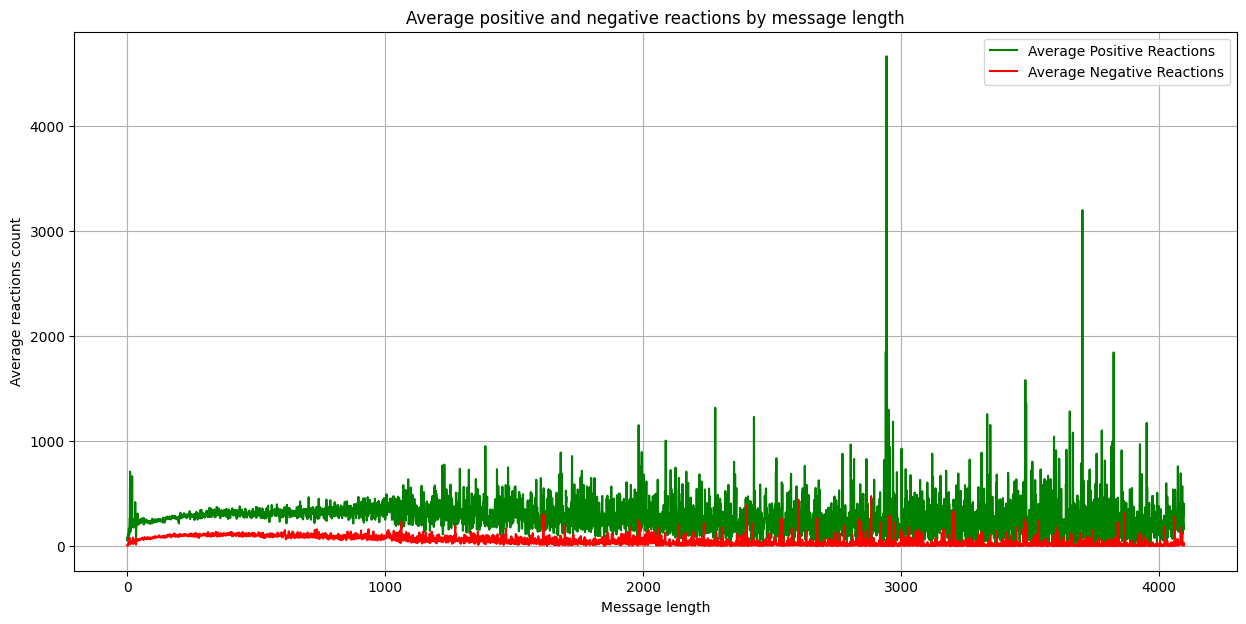

In [8]:
df['message_length'] = df['message'].apply(lambda x: len(x) if pd.notnull(x) else 0)

message_length_reactions = df.groupby('message_length').agg({
    'positive_reactions_count': 'mean',
    'negative_reactions_count': 'mean'
}).reset_index()

plt.figure(figsize=(15, 7))
plt.plot(message_length_reactions['message_length'], message_length_reactions['positive_reactions_count'], label='Average Positive Reactions', color='green')
plt.plot(message_length_reactions['message_length'], message_length_reactions['negative_reactions_count'], label='Average Negative Reactions', color='red')
plt.xlabel('Message length')
plt.ylabel('Average reactions count')
plt.title('Average positive and negative reactions by message length')
plt.legend()
plt.grid(True)
plt.show()

## 3. Which days of the week are the most active for publications in propaganda channels?
### Answer: Thursday and wednesday are the most active days for publications


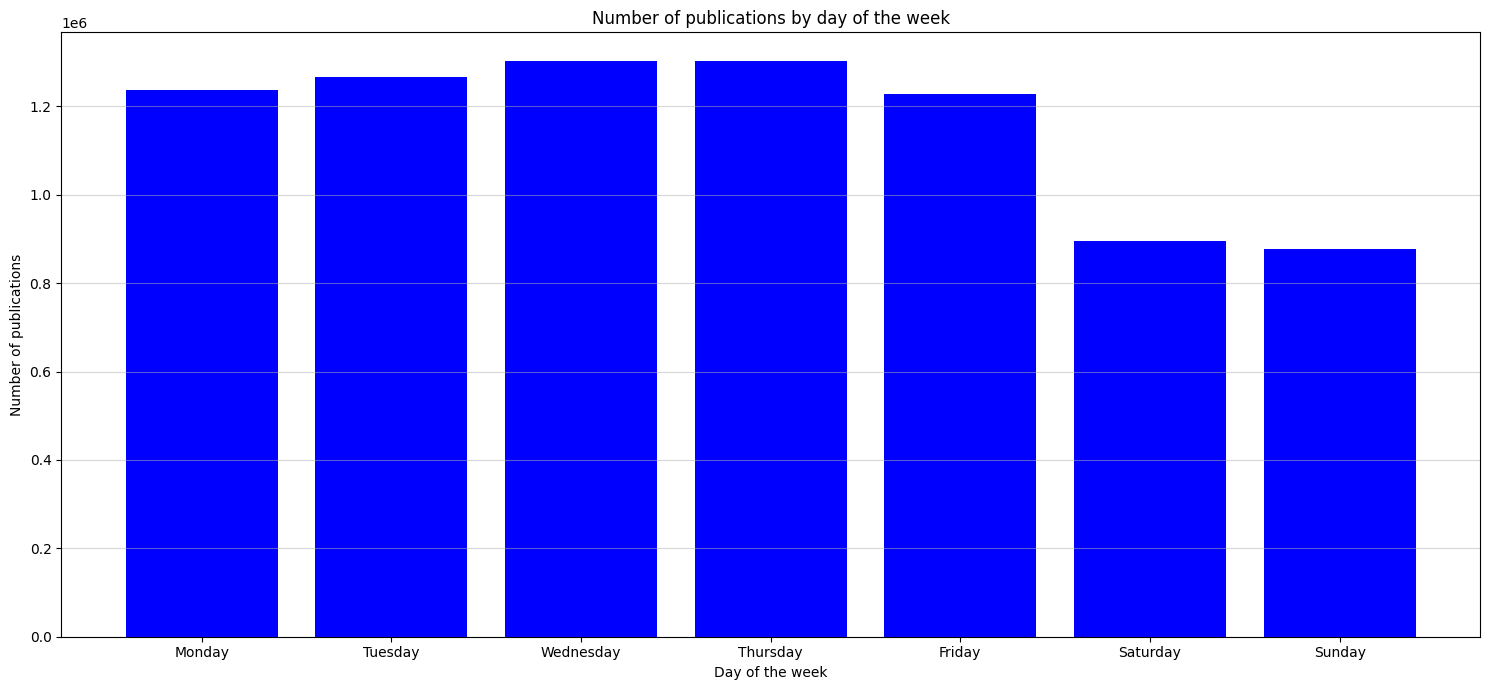

In [9]:
df['date'] = pd.to_datetime(df['date'])

df['day_of_week'] = df['date'].dt.day_name()

days_activity = df['day_of_week'].value_counts()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_activity = days_activity.reindex(days_order)

plt.figure(figsize=(15, 7))
plt.bar(days_activity.index, days_activity.values, color='blue')
plt.xlabel('Day of the week')
plt.ylabel('Number of publications')
plt.title('Number of publications by day of the week')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

## 4. Which types of messages receive the highest average number of positive reactions?
### Answer: video

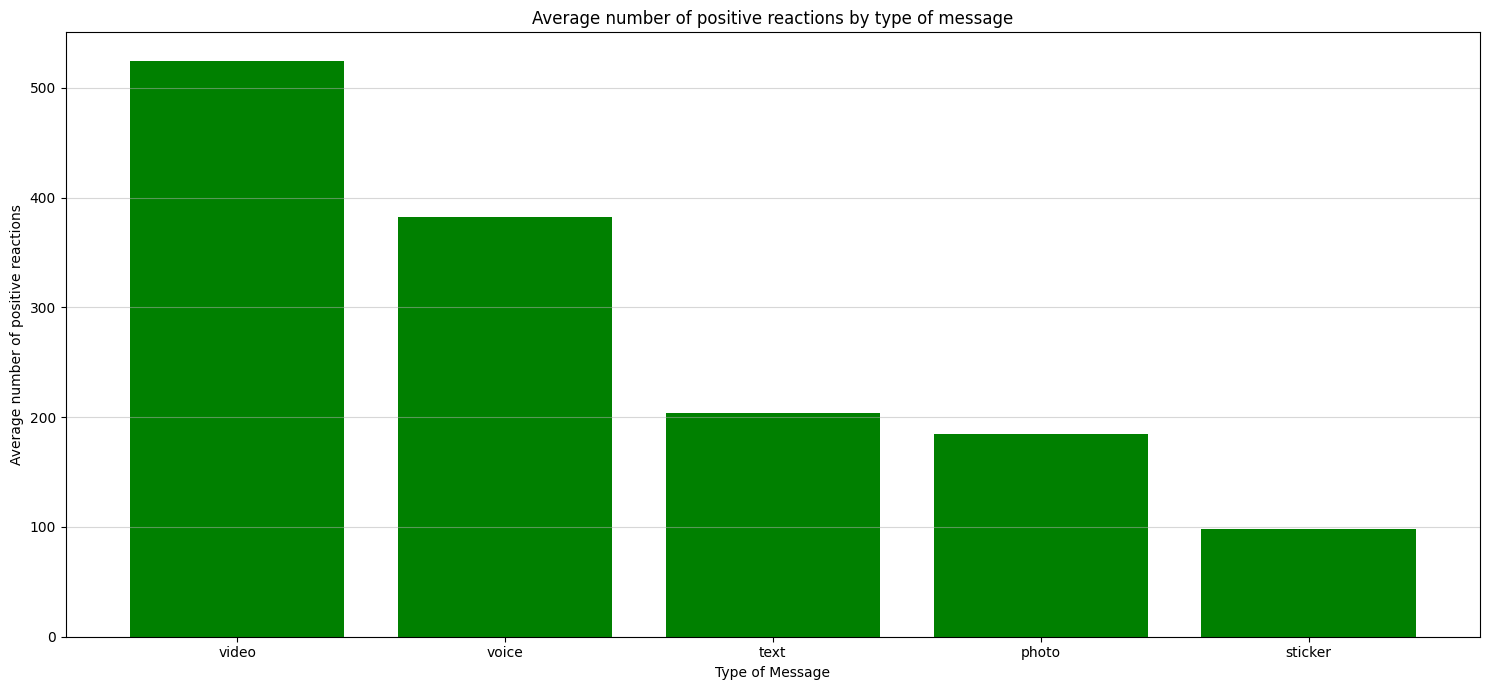

In [10]:
df['type'] = df['type'].astype('category')

type_positive_reactions = df.groupby('type', observed=False)['positive_reactions_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 7))
plt.bar(type_positive_reactions.index, type_positive_reactions.values, color='green')
plt.xlabel('Type of Message')
plt.ylabel('Average number of positive reactions')
plt.title('Average number of positive reactions by type of message')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


## 5. Do messages forwarded from other channels (fwd_from) receive more reactions compared to original messages?
### Answer: No

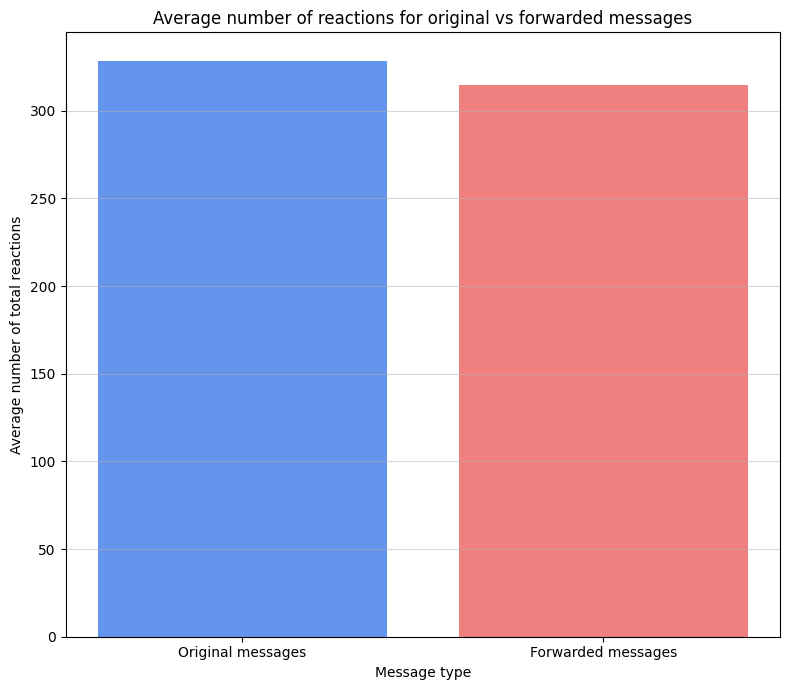

In [68]:
df['is_forwarded'] = df['fwd_from'].notnull()

forwarded_reactions = df.groupby('is_forwarded')['total_reactions_count'].mean()

forwarded_reactions.index = ['Original messages', 'Forwarded messages']

plt.figure(figsize=(8, 7))
plt.bar(forwarded_reactions.index, forwarded_reactions.values, color=['cornflowerblue', 'lightcoral'])
plt.xlabel('Message type')
plt.ylabel('Average number of total reactions')
plt.title('Average number of reactions for original vs forwarded messages')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


## 6. What are the common reactions to messages containing the word “герой”?

In [7]:
hero_messages = df[df['message'].str.contains('герой', case=False, na=False)]

def extract_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return {}
    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    reactions_count = {}
    for emoji, num in matches:
        if emoji in reactions_count:
            reactions_count[emoji] += int(num)
        else:
            reactions_count[emoji] = int(num)
    return reactions_count

total_reactions_count = {}
for reactions_dict in hero_messages['reactions'].apply(extract_reactions):
    for emoji, count in reactions_dict.items():
        if emoji in total_reactions_count:
            total_reactions_count[emoji] += count
        else:
            total_reactions_count[emoji] = count

sorted_reactions = sorted(total_reactions_count.items(), key=lambda x: x[1], reverse=True)

print("Most common reactions to messages containing the word 'герой':")
for reaction, count in sorted_reactions:
    print(f"{reaction}: {count}")


Most common reactions to messages containing the word 'герой':
👍: 8034525
❤: 3138515
😢: 1913448
🔥: 675624
😁: 449326
👏: 398739
🤬: 274047
👎: 222894
🤮: 151237
💩: 124148
🙏: 106398
🤔: 98531
😱: 74304
❤\u200d🔥: 66852
🤡: 46877
🥰: 41510
🤯: 36534
🤣: 30237
🕊: 14317
💯: 11505
🎉: 11120
💔: 5620
🤩: 1957
🍌: 1834
⚡: 1623
🥴: 1478
🐳: 857
😍: 775
🍾: 737
😐: 688
🖕: 534
🏆: 408
🥱: 393
\U0001fae1: 380
🌚: 332
🌭: 330
🤨: 285
👌: 176
👻: 63
😈: 48
💋: 34
👀: 24
🤝: 4
🎃: 3
😴: 1
😭: 1


## 7. Are there differences in how often the word “переговоры” is used in high-view channels compared to low-view channels?
### Answer: Yes, there is a difference. "Переговоры" is most used in high-view channels rather than low-view.

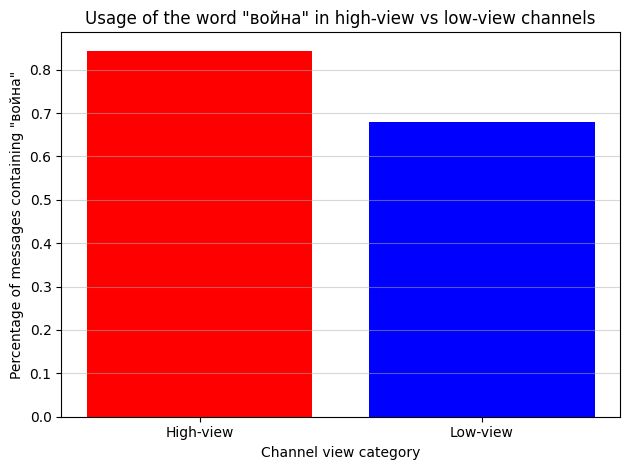

In [52]:
view_threshold = df['views'].median()

df['view_category'] = df['views'].apply(lambda x: 'High-view' if x >= view_threshold else 'Low-view')

df['contains_war'] = df['message'].str.contains('война', case=False, na=False)

word_usage_counts = df.groupby('view_category')['contains_war'].sum()

total_messages_counts = df['view_category'].value_counts()

word_usage_percentage = (word_usage_counts / total_messages_counts) * 100

plt.bar(word_usage_percentage.index, word_usage_percentage.values, color=['red', 'blue'])
plt.xlabel('Channel view category')
plt.ylabel('Percentage of messages containing "война"')
plt.title('Usage of the word "война" in high-view vs low-view channels')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


## 8. How usage of "война" and "сво" changed in time

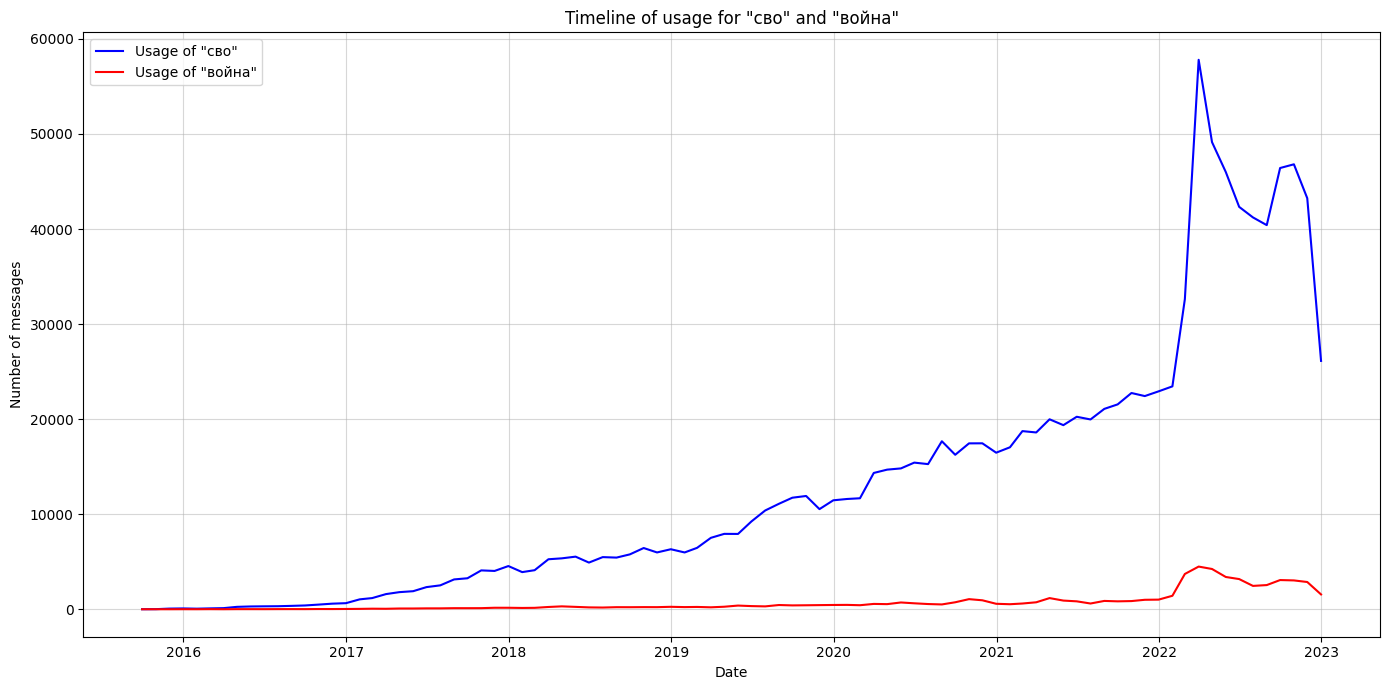

In [54]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['contains_svo'] = df['message'].str.contains('сво', case=False, na=False)
df['contains_war'] = df['message'].str.contains('война', case=False, na=False)

timeline_usage = df.resample('ME', on='date').agg({
    'contains_svo': 'sum',
    'contains_war': 'sum'
}).reset_index()

plt.figure(figsize=(14, 7))
plt.plot(timeline_usage['date'], timeline_usage['contains_svo'], label='Usage of "сво"', color='blue')
plt.plot(timeline_usage['date'], timeline_usage['contains_war'], label='Usage of "война"', color='red')
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.title('Timeline of usage for "сво" and "война"')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Reactions patterns to messages containing words "Путин" and "Зеленский"

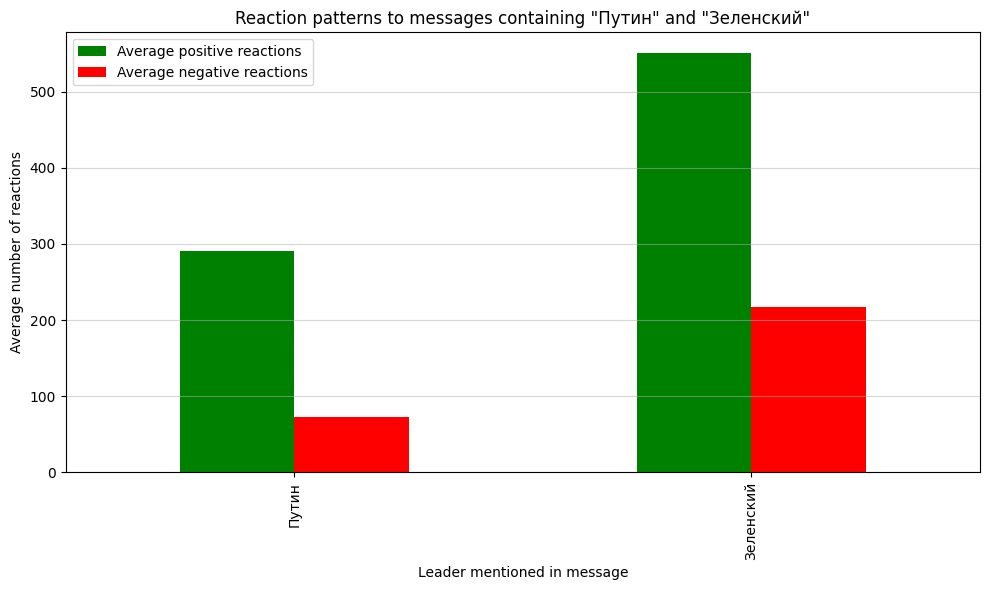

In [57]:
df['contains_putin'] = df['message'].str.contains('Путин', case=False, na=False)
df['contains_zelensky'] = df['message'].str.contains('Зеленский', case=False, na=False)

putin_messages = df[df['contains_putin']]
zelensky_messages = df[df['contains_zelensky']]

putin_avg_positive = putin_messages['positive_reactions_count'].mean()
putin_avg_negative = putin_messages['negative_reactions_count'].mean()

zelensky_avg_positive = zelensky_messages['positive_reactions_count'].mean()
zelensky_avg_negative = zelensky_messages['negative_reactions_count'].mean()

reactions_summary = pd.DataFrame({
    'Leader': ['Путин', 'Зеленский'],
    'Average positive reactions': [putin_avg_positive, zelensky_avg_positive],
    'Average negative reactions': [putin_avg_negative, zelensky_avg_negative]
})

reactions_summary.set_index('Leader').plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.xlabel('Leader mentioned in message')
plt.ylabel('Average number of reactions')
plt.title('Reaction patterns to messages containing "Путин" and "Зеленский"')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

## 10. What are the most frequent bigrams?

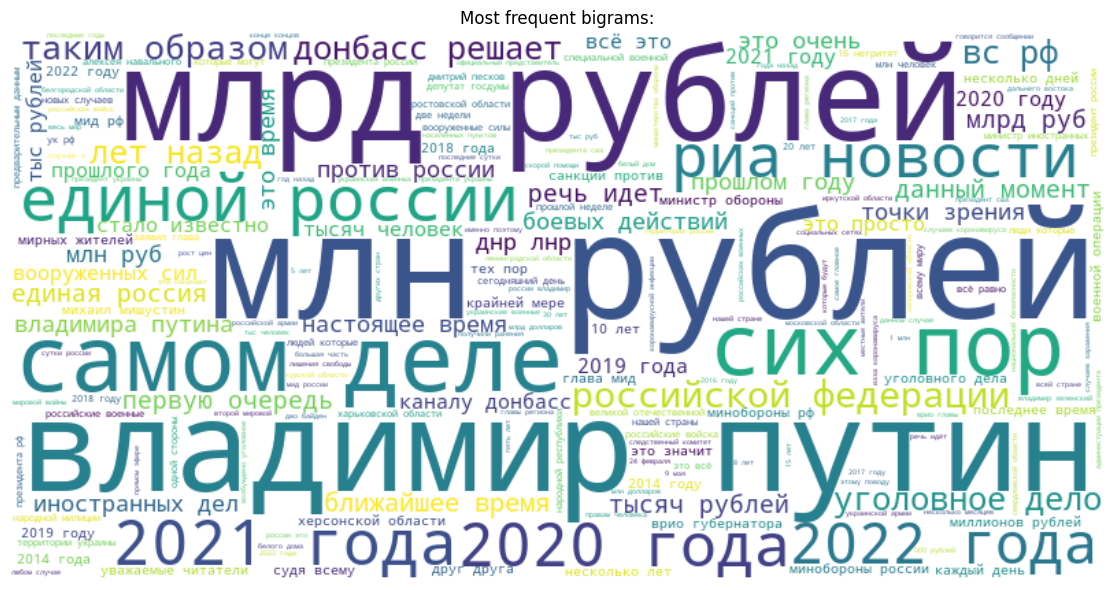

In [3]:
subset_size = len(df) // 5
small_df = df.iloc[:subset_size].copy()

stop_words = set(stopwords.words('russian'))
small_df.loc[:, 'message'] = small_df['message'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
small_df.loc[:, 'tokens'] = small_df['message'].apply(nltk.word_tokenize)
small_df.loc[:, 'filtered_tokens'] = small_df['tokens'].apply(lambda words: [word for word in words if word not in stop_words])

bigram_counter = Counter()
for tokens in small_df['filtered_tokens']:
    bigram_counter.update(bigrams(tokens))

gc.collect()

bigram_word_cloud_data = {' '.join(bigram): count for bigram, count in bigram_counter.items()}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_word_cloud_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent bigrams:')
plt.tight_layout()
plt.show()

## 11. Most common words before and after "россия"

In [7]:
keyword = "россия"

subset_size = len(df) // 10
subset_df = df.iloc[:subset_size].copy()

subset_df.loc[:, 'message'] = subset_df['message'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
subset_df.loc[:, 'tokens'] = subset_df['message'].apply(nltk.word_tokenize)

before_words = Counter()
after_words = Counter()

for tokens in subset_df['tokens']:
    for i in range(1, len(tokens) - 1):
        if tokens[i] == keyword:
            before_words[tokens[i - 1]] += 1
            after_words[tokens[i + 1]] += 1

print(f"Most common words before '{keyword}':")
for word, count in before_words.most_common(10):
    print(f"{word}: {count}")

print(f"\nMost common words after '{keyword}':")
for word, count in after_words.most_common(10):
    print(f"{word}: {count}")

Most common words before 'россия':
что: 3432
единая: 1046
и: 876
если: 425
справедливая: 382
как: 320
а: 299
не: 182
когда: 172
чтобы: 171

Most common words after 'россия':
не: 1407
и: 1177
в: 737
может: 470
будет: 404
украина: 380
должна: 337
1: 260
24: 248
за: 226


## 5 HW version:

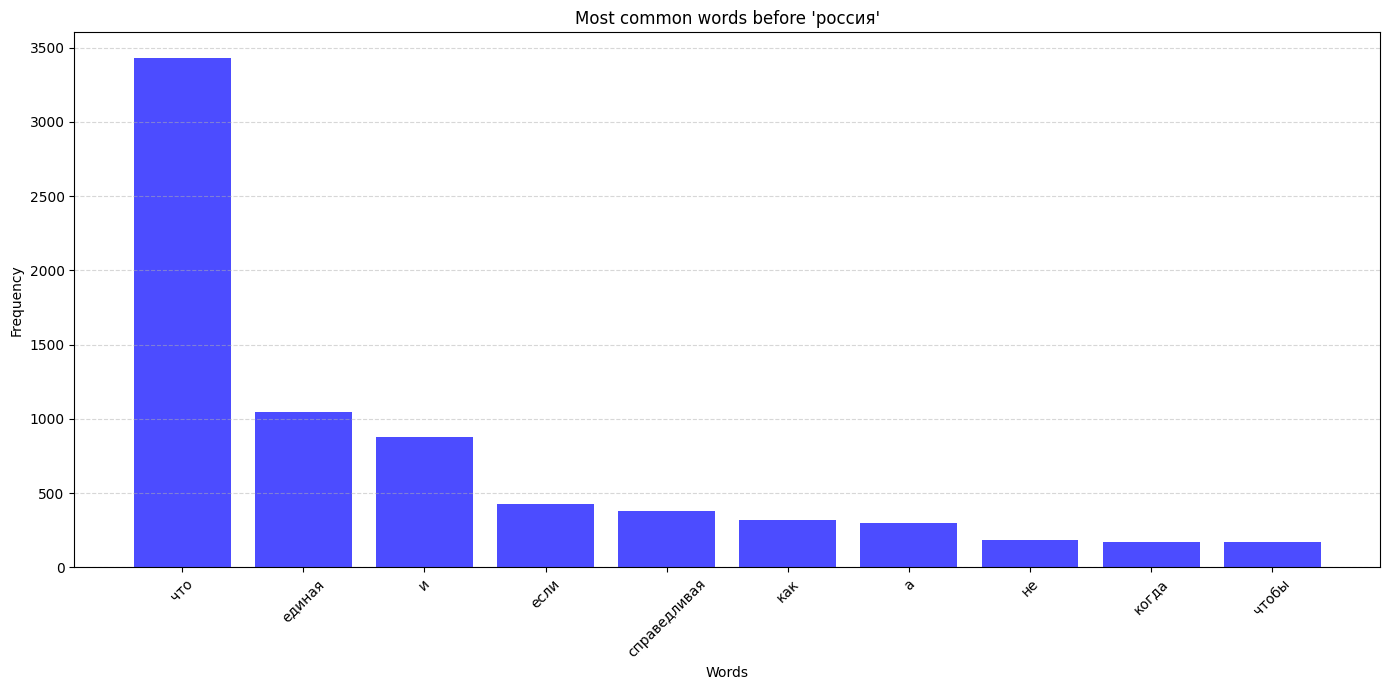

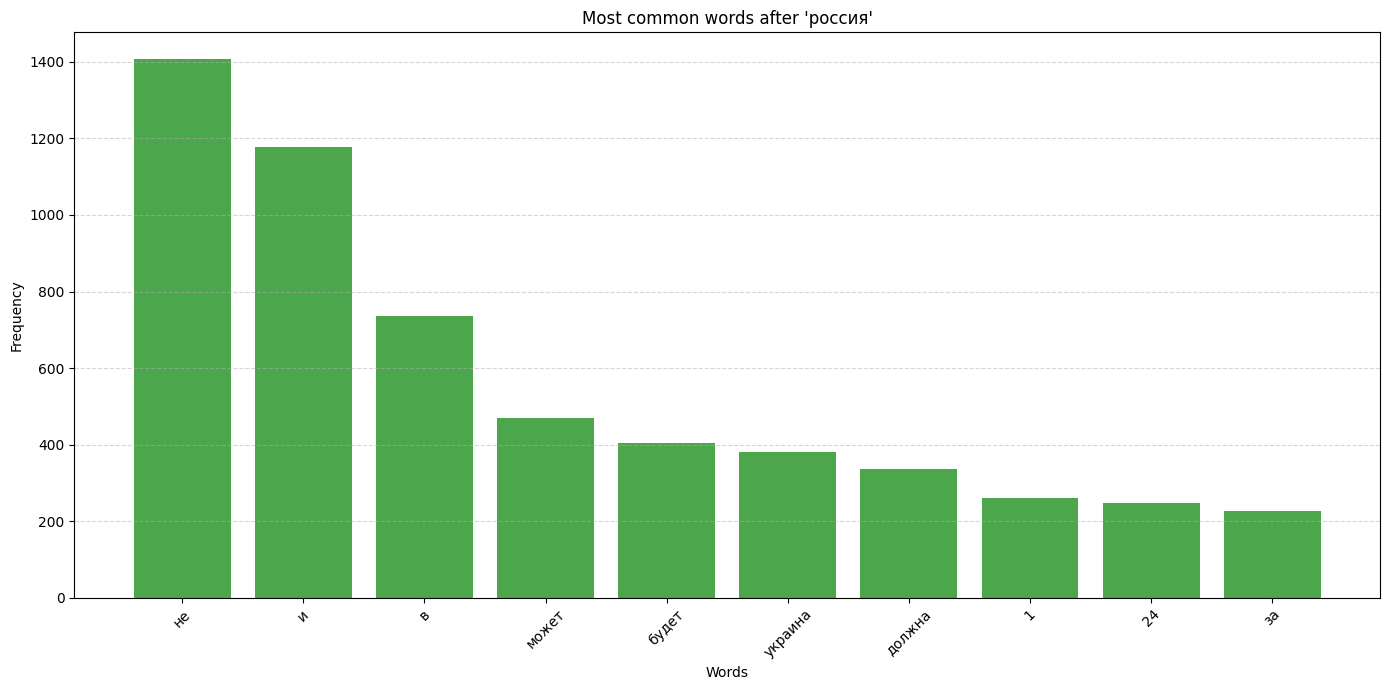

In [3]:
import matplotlib.pyplot as plt

keyword = "россия"

subset_size = len(df) // 10
subset_df = df.iloc[:subset_size].copy()

subset_df.loc[:, 'message'] = subset_df['message'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
subset_df.loc[:, 'tokens'] = subset_df['message'].apply(nltk.word_tokenize)

before_words = Counter()
after_words = Counter()

for tokens in subset_df['tokens']:
    for i in range(1, len(tokens) - 1):
        if tokens[i] == keyword:
            before_words[tokens[i - 1]] += 1
            after_words[tokens[i + 1]] += 1

top_before_words = before_words.most_common(10)
top_after_words = after_words.most_common(10)

before_words_labels, before_words_counts = zip(*top_before_words)
after_words_labels, after_words_counts = zip(*top_after_words)

plt.figure(figsize=(14, 7))
plt.bar(before_words_labels, before_words_counts, color='blue', alpha=0.7)
plt.title(f"Most common words before '{keyword}'")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.bar(after_words_labels, after_words_counts, color='green', alpha=0.7)
plt.title(f"Most common words after '{keyword}'")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 12. Most common bigrams in messages with negative reactions

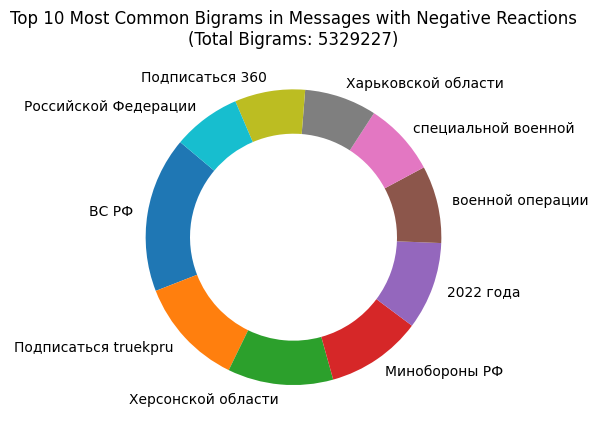

In [18]:
negative_reactions = ['👎', '😢', '🤮', '🤡', '🤬', '💩', '😱']
stop_words = set(stopwords.words('russian'))
df_sample = df.sample(frac=0.1, random_state=42).copy()

def extract_reactions(reactions_str):
    if pd.isnull(reactions_str) or 'results=' not in reactions_str:
        return []
    matches = re.findall(r"reaction='(.*?)', count=(\d+)", reactions_str)
    reactions_count = {}
    for emoji, num in matches:
        if emoji in reactions_count:
            reactions_count[emoji] += int(num)
        else:
            reactions_count[emoji] = int(num)
    return reactions_count

df_sample['reactions_dict'] = df_sample['reactions'].apply(extract_reactions)

def has_negative_reactions(reactions_dict):
    return any(emoji in reactions_dict for emoji in negative_reactions)

df_negative_reactions = df_sample[df_sample['reactions_dict'].apply(has_negative_reactions)].copy()

def get_ngrams(text, n=2):
    words = [word for word in nltk.word_tokenize(text) if word.isalnum() and word.lower() not in stop_words]
    return list(ngrams(words, n))

bigram_counter = Counter()
for message in df_negative_reactions['message'].dropna():
    bigram_counter.update(get_ngrams(message))

most_common_bigrams = bigram_counter.most_common(10)
total_bigrams_count = sum(bigram_counter.values())

labels = [" ".join(bigram) for bigram, _ in most_common_bigrams]
sizes = [count for _, count in most_common_bigrams]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, startangle=140, wedgeprops=dict(width=0.3))
ax.set(aspect="equal")
plt.title(f"Top 10 Most Common Bigrams in Messages with Negative Reactions\n(Total Bigrams: {total_bigrams_count})")
plt.show()



## 13. Which channels that use hyperbolic language, such as extreme adjectives and adverbs in their messages? How does the use of such language correlate with the number of views, positive reactions, and negative reactions?

Channels that frequently use hyperbolic language and their engagement statistics:
                          views  positive_reactions_percentage  \
dialog_id                                                        
swodki             47616.148438                      56.765852   
glavmedia           4848.219238                      80.305755   
SolovievLive      137819.812500                      87.930428   
truekpru           19529.734375                      84.322794   
readovkanews      246035.687500                      68.090881   
...                         ...                            ...   
truth_aggregator    7520.565430                            NaN   
youlistenedmayak   25798.416016                            NaN   
zakharprilepin     83224.718750                            NaN   
Alekhin_Telega     13063.484375                            NaN   
zvezdanews          9909.117188                            NaN   

                  negative_reactions_percentage  
dialog_id

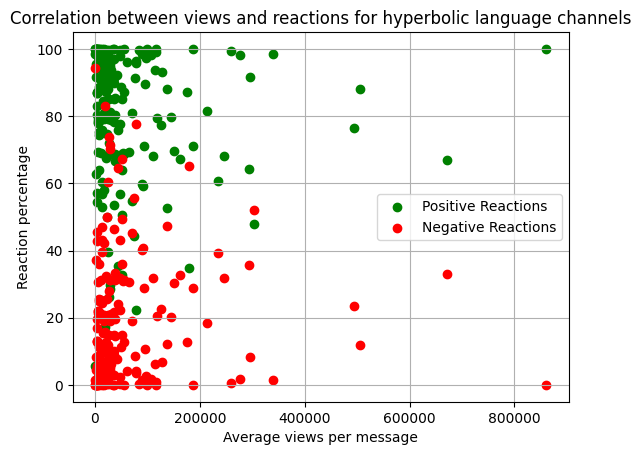

In [14]:
hyperbolic_words = ['самый', 'беспрецедентный', 'колоссальный', 'огромный', 'невероятный', 'грандиозный']

def contains_hyperbolic_language(message):
    words = nltk.word_tokenize(message)
    return any(word.lower() in hyperbolic_words for word in words)

df_sample = df.sample(frac=0.1, random_state=42).copy()

df_sample['contains_hyperbolic'] = df_sample['message'].apply(lambda x: contains_hyperbolic_language(x) if pd.notnull(x) else False)

hyperbolic_df = df_sample[df_sample['contains_hyperbolic']]

channel_analysis = hyperbolic_df.groupby('dialog_id').agg({
    'views': 'mean',
    'reactions': 'count',
    'positive_reactions_count': 'sum',
    'negative_reactions_count': 'sum'
}).sort_values(by='reactions', ascending=False)

channel_analysis['total_reactions_count'] = channel_analysis['positive_reactions_count'] + channel_analysis['negative_reactions_count']

channel_analysis['positive_reactions_percentage'] = (channel_analysis['positive_reactions_count'] / channel_analysis['total_reactions_count']) * 100
channel_analysis['negative_reactions_percentage'] = (channel_analysis['negative_reactions_count'] / channel_analysis['total_reactions_count']) * 100

print("Channels that frequently use hyperbolic language and their engagement statistics:")
print(channel_analysis[['views', 'positive_reactions_percentage', 'negative_reactions_percentage']])

plt.scatter(channel_analysis['views'], channel_analysis['positive_reactions_percentage'], color='green', label='Positive Reactions')
plt.scatter(channel_analysis['views'], channel_analysis['negative_reactions_percentage'], color='red', label='Negative Reactions')
plt.xlabel('Average views per message')
plt.ylabel('Reaction percentage')
plt.title('Correlation between views and reactions for hyperbolic language channels')
plt.legend()
plt.grid(True)
plt.show()


## 5 HW version:

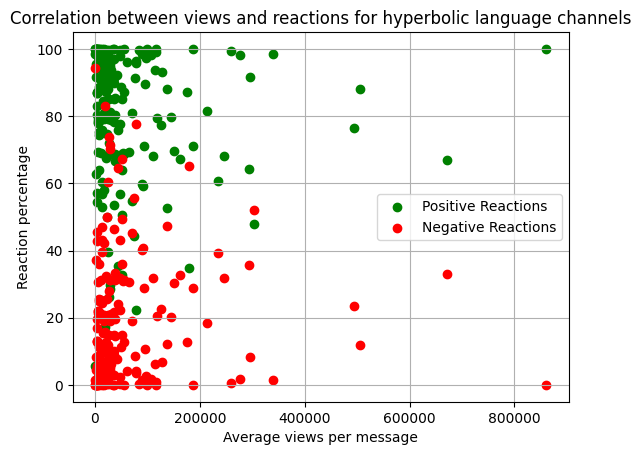

In [10]:
hyperbolic_words = ['самый', 'беспрецедентный', 'колоссальный', 'огромный', 'невероятный', 'грандиозный']

def contains_hyperbolic_language(message):
    words = nltk.word_tokenize(message)
    return any(word.lower() in hyperbolic_words for word in words)

df_sample = df.sample(frac=0.1, random_state=42).copy()

df_sample['contains_hyperbolic'] = df_sample['message'].apply(lambda x: contains_hyperbolic_language(x) if pd.notnull(x) else False)

hyperbolic_df = df_sample[df_sample['contains_hyperbolic']]

channel_analysis = hyperbolic_df.groupby('dialog_id').agg({
    'views': 'mean',
    'reactions': 'count',
    'positive_reactions_count': 'sum',
    'negative_reactions_count': 'sum'
}).sort_values(by='reactions', ascending=False)

channel_analysis['total_reactions_count'] = channel_analysis['positive_reactions_count'] + channel_analysis['negative_reactions_count']

channel_analysis['positive_reactions_percentage'] = (channel_analysis['positive_reactions_count'] / channel_analysis['total_reactions_count']) * 100
channel_analysis['negative_reactions_percentage'] = (channel_analysis['negative_reactions_count'] / channel_analysis['total_reactions_count']) * 100

plt.scatter(channel_analysis['views'], channel_analysis['positive_reactions_percentage'], color='green', label='Positive Reactions')
plt.scatter(channel_analysis['views'], channel_analysis['negative_reactions_percentage'], color='red', label='Negative Reactions')
plt.xlabel('Average views per message')
plt.ylabel('Reaction percentage')
plt.title('Correlation between views and reactions for hyperbolic language channels')
plt.legend()
plt.grid(True)
plt.show()



## 14. Which channels have the highest frequency of mentions of Western countries?

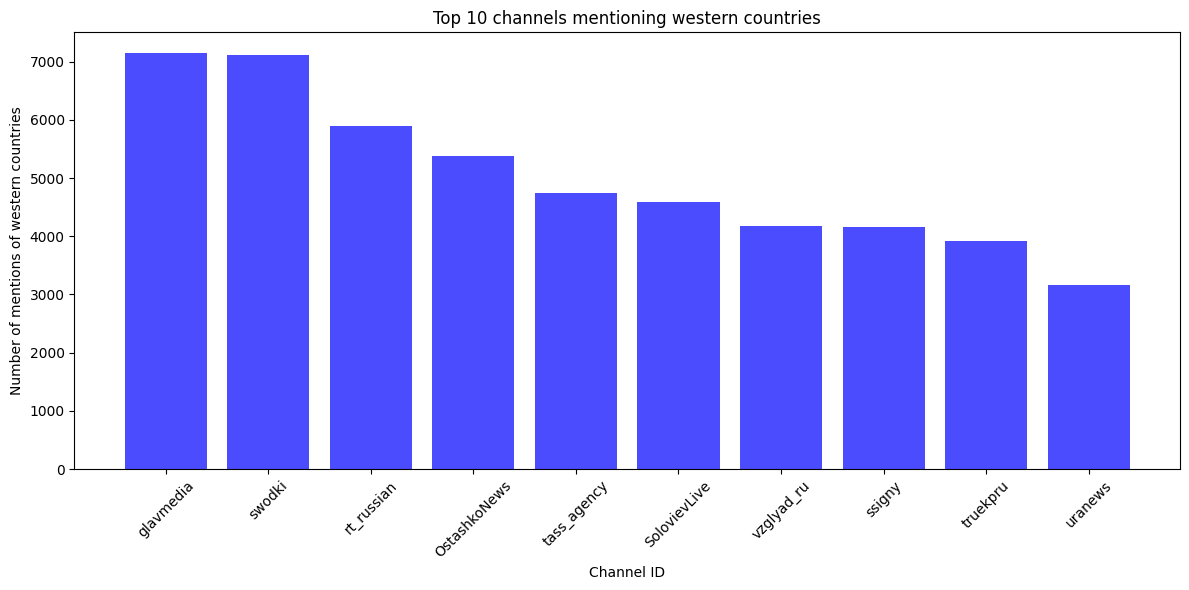

In [15]:
western_countries = [
    'Андорра', 'Австралия', 'Австрия', 'Бельгия', 'Канада', 'Хорватия', 'Чехия',
    'Дания', 'Эстония', 'Финляндия', 'Франция', 'Германия', 'Венгрия', 'Исландия',
    'Ирландия', 'Италия', 'Латвия', 'Лихтенштейн', 'Литва', 'Люксембург', 'Монако',
    'Нидерланды', 'Новая Зеландия', 'Норвегия', 'Португалия', 'Польша', 'Сан-Марино',
    'Словакия', 'Словения', 'Испания', 'Швеция', 'Швейцария', 'Великобритания',
    'США', 'Ватикан'
]

def mentions_western_country(message):
    if pd.isnull(message):
        return []
    mentioned_countries = [country for country in western_countries if country in message]
    return mentioned_countries

df['western_mentions'] = df['message'].apply(mentions_western_country)

df['has_western_mentions'] = df['western_mentions'].apply(lambda x: len(x) > 0)

df_western_mentions = df[df['has_western_mentions']].copy()

df['positive_reactions_percentage'] = (df['positive_reactions_count'] / df['total_reactions_count']) * 100
df['negative_reactions_percentage'] = (df['negative_reactions_count'] / df['total_reactions_count']) * 100

channel_analysis = df_western_mentions.groupby('dialog_id').agg({
    'western_mentions': 'count',
    'views': 'mean',
    'reactions': 'count',
    'positive_reactions_count': 'sum',
    'negative_reactions_count': 'sum',
    'positive_reactions_percentage': 'mean',  
    'negative_reactions_percentage': 'mean'
}).sort_values(by='western_mentions', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(channel_analysis.index[:10], channel_analysis['western_mentions'].head(10), color='blue', alpha=0.7)
plt.xlabel('Channel ID')
plt.ylabel('Number of mentions of western countries')
plt.title('Top 10 channels mentioning western countries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 15. What words or phrases are most frequently used in the same sentences as "украинцы". 

Most frequent words or phrases in sentences with 'украинцы':


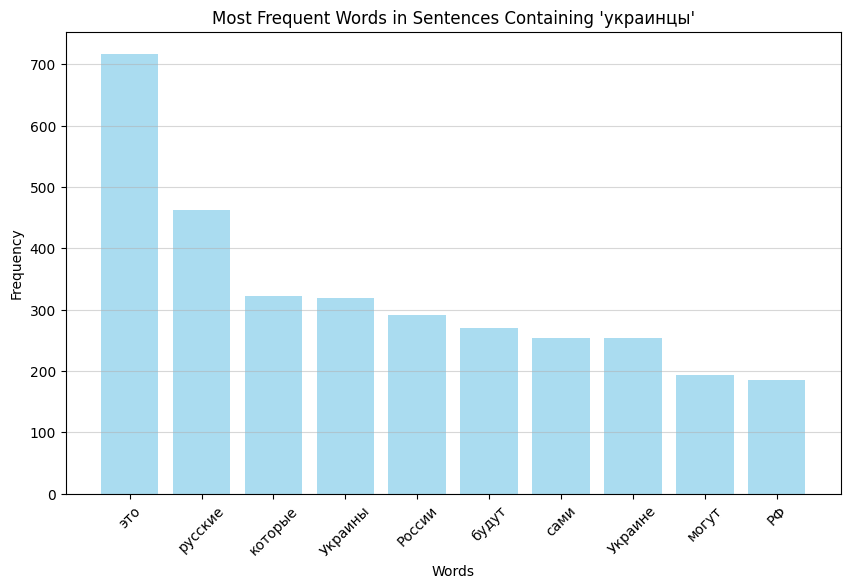

In [3]:
def extract_sentences_with_target(text, target_word):
    if pd.isnull(text):
        return []
    sentences = sent_tokenize(text)
    return [sentence for sentence in sentences if target_word in sentence]

def get_frequent_words(sentences, stop_words, target_word, n=10):
    word_counter = Counter()
    for sentence in sentences:
        words = [word for word in word_tokenize(sentence) if word.isalnum() and word.lower() not in stop_words]
        words = [word for word in words if word.lower() != target_word]
        word_counter.update(words)
    return word_counter.most_common(n)

stop_words = set(nltk.corpus.stopwords.words('russian'))
df_sample = df.sample(frac=0.3).copy()

sentences_with_target = []
for message in df_sample['message']:
    sentences_with_target.extend(extract_sentences_with_target(message, 'украинцы'))

most_common_words = get_frequent_words(sentences_with_target, stop_words, 'украинцы')

print("Most frequent words or phrases in sentences with 'украинцы':")

words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue', alpha=0.7)
plt.title("Most frequent words in sentences containing 'украинцы'")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

## 16. Which channels have the highest engagement rates (reactions per view)?

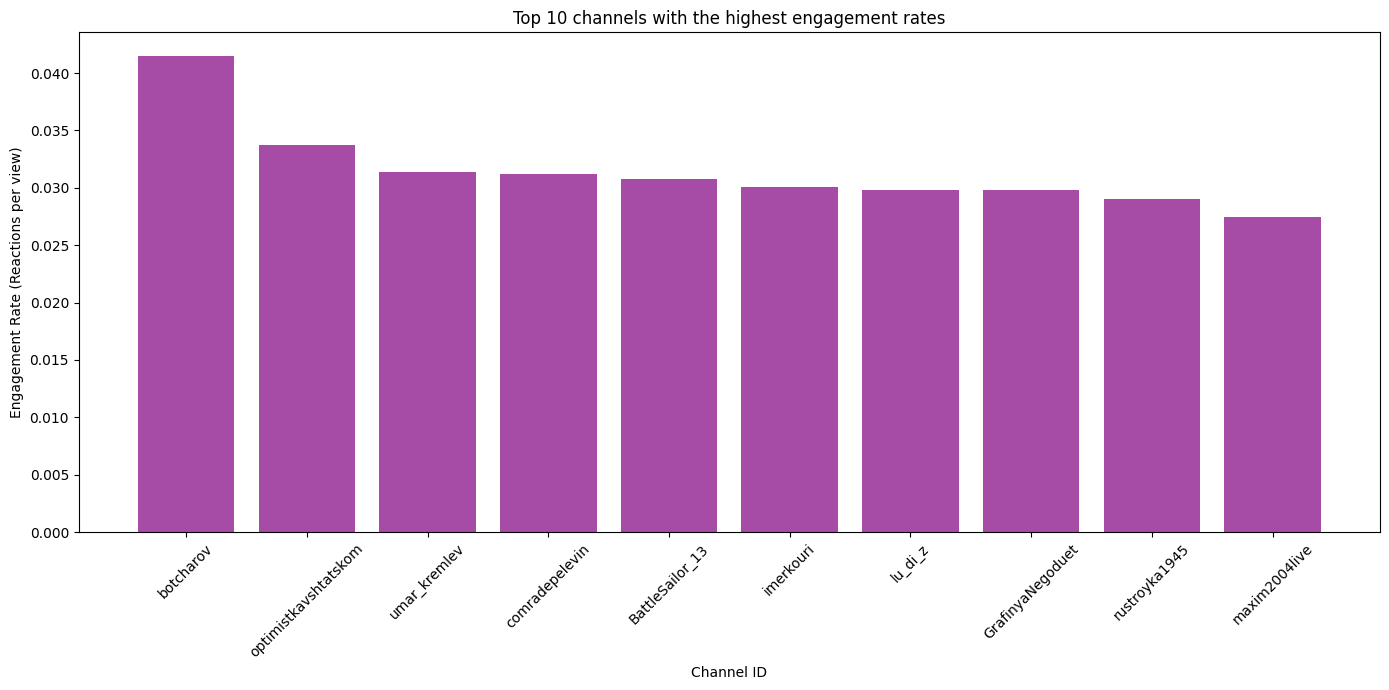

In [34]:
df['views'] = pd.to_numeric(df['views'], errors='coerce')

df['engagement_rate'] = df['total_reactions_count'] / df['views']

channel_engagement = df.groupby('dialog_id')['engagement_rate'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 7))
plt.bar(channel_engagement.index, channel_engagement.values, color='purple', alpha=0.7)
plt.xlabel('Channel ID')
plt.ylabel('Engagement rate (reactions per view)')
plt.title('Top 10 channels with the highest engagement rates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 17. How does the use of words like "война" or "мир" correlate with audience reactions?
### Messages that contain "мир" have much more reactions, than messages that contain "война"

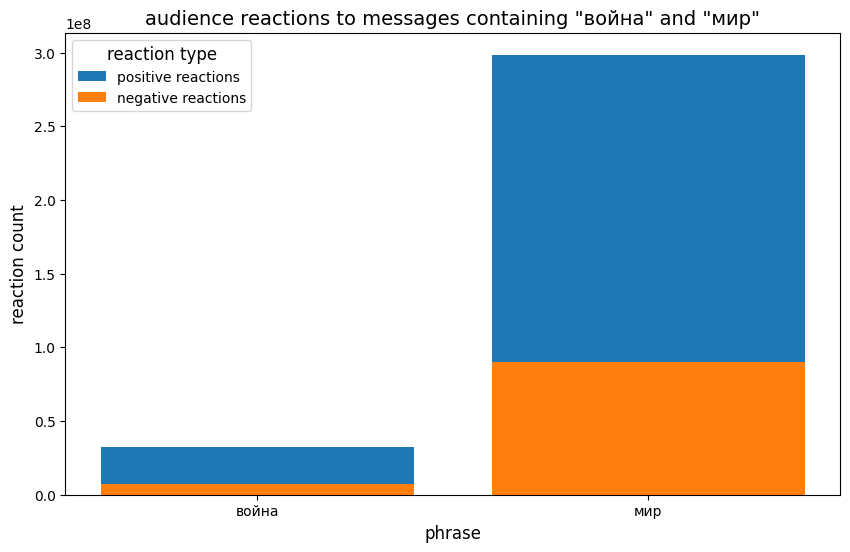

In [6]:
war_df = df[df['message'].str.contains('война', case=False, na=False)]
peace_df = df[df['message'].str.contains('мир', case=False, na=False)]

phrase_data = pd.DataFrame({
    'phrase': ['война', 'мир'],
    'positive reactions': [
        war_df['positive_reactions_count'].sum(),
        peace_df['positive_reactions_count'].sum()
    ],
    'negative reactions': [
        war_df['negative_reactions_count'].sum(),
        peace_df['negative_reactions_count'].sum()
    ]
})

melted_phrase_data = phrase_data.melt(id_vars='phrase', var_name='reaction type', value_name='count')

fig, ax = plt.subplots(figsize=(10, 6))
for reaction_type in melted_phrase_data['reaction type'].unique():
    subset = melted_phrase_data[melted_phrase_data['reaction type'] == reaction_type]
    ax.bar(subset['phrase'], subset['count'], label=reaction_type)

ax.set_title('audience reactions to messages containing "война" and "мир"')
ax.set_xlabel('phrase')
ax.set_ylabel('reaction count')

ax.legend(title='reaction type')

plt.show()


## 18. Are there specific phrases that are consistently present in messages with the highest positive reactions?

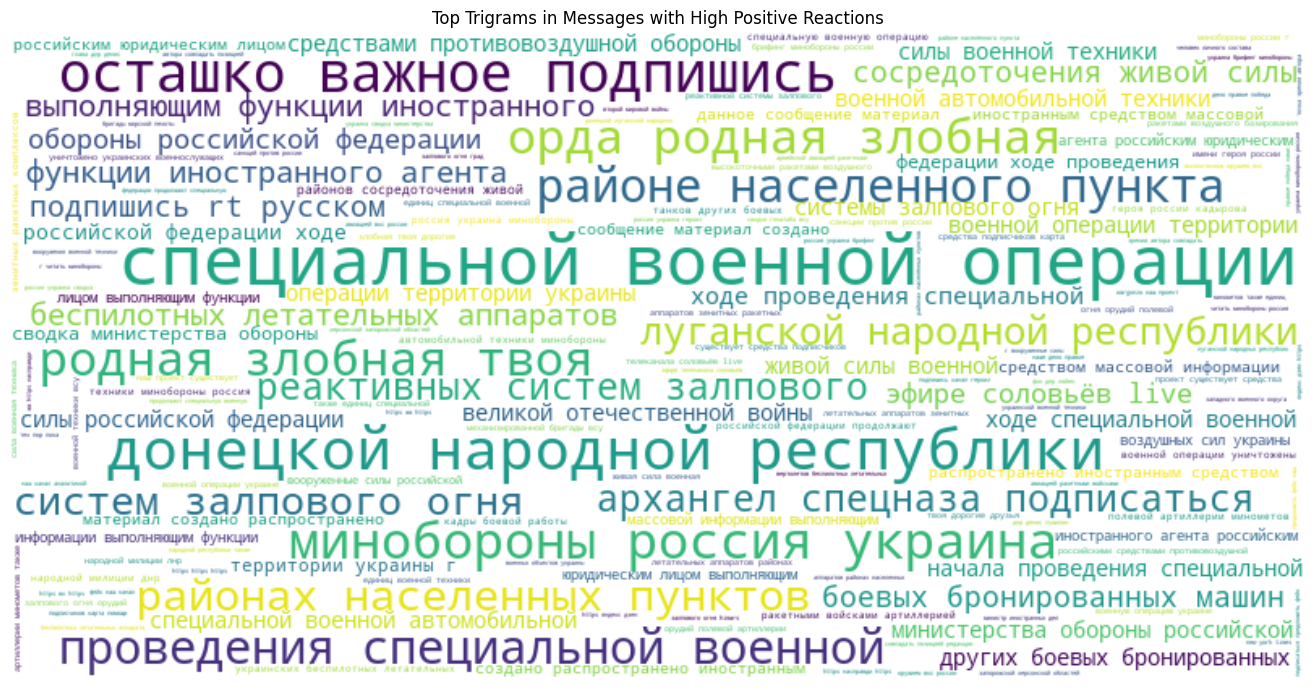

In [16]:
high_positive_threshold = df['positive_reactions_count'].quantile(0.9)

high_positive_df = df[df['positive_reactions_count'] >= high_positive_threshold]

all_text = ' '.join(high_positive_df['message'].dropna()).lower()

words = [word for word in word_tokenize(all_text) if word.isalpha() and word not in stop_words]

trigrams_list = list(ngrams(words, 3))

common_trigrams = Counter(trigrams_list)

trigram_wordcloud_data = {' '.join(trigram): count for trigram, count in common_trigrams.items()}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_wordcloud_data)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Trigrams in Messages with High Positive Reactions')
plt.tight_layout()
plt.show()

## 19. Trend of new channels creation over time

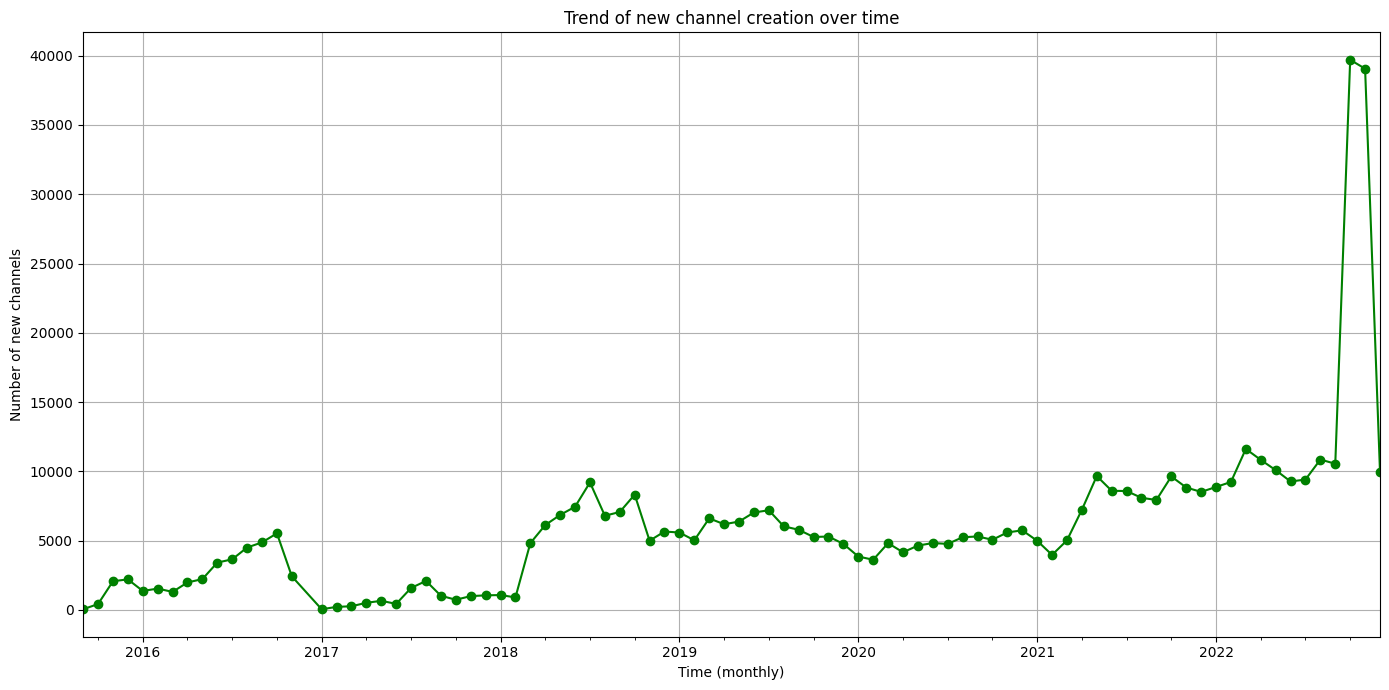

In [16]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True).dt.tz_localize(None)

channel_creation_dates = df.groupby('id')['date'].min()

channel_creation_df = channel_creation_dates.reset_index()
channel_creation_df.columns = ['channel_id', 'creation_date']

channels_per_month = channel_creation_df.groupby(channel_creation_df['creation_date'].dt.to_period('M')).size()

plt.figure(figsize=(14, 7))
channels_per_month.plot(kind='line', marker='o', color='green')
plt.xlabel('Time (monthly)')
plt.ylabel('Number of new channels')
plt.title('Trend of new channel creation over time')
plt.grid(True)
plt.tight_layout()
plt.show()


## 20. Is there a seasonal pattern in the number of views or reactions received?
### Yes. There are more views and reactions in Spring.

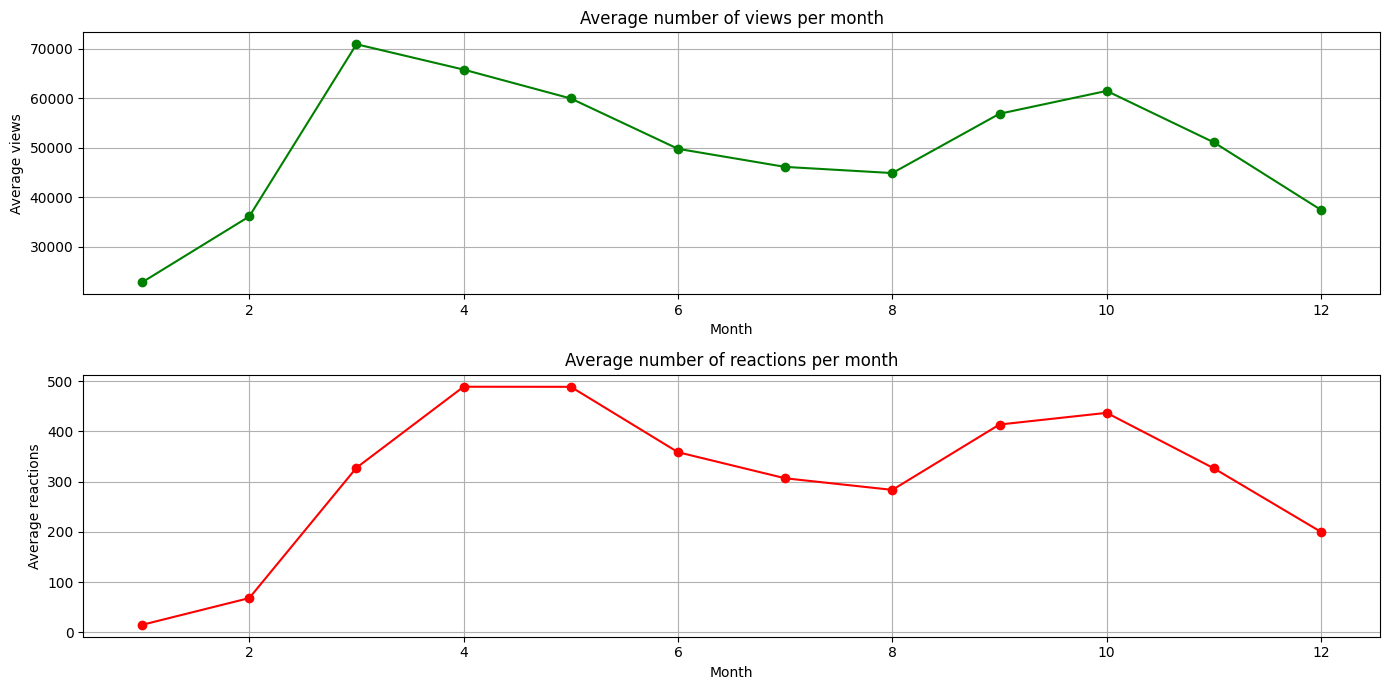

In [23]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month

seasonal_views = df.groupby('month')['views'].mean()
seasonal_reactions = df.groupby('month')['total_reactions_count'].mean()

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(seasonal_views.index, seasonal_views.values, marker='o', linestyle='-', color='green')
plt.title('Average number of views per month')
plt.xlabel('Month')
plt.ylabel('Average views')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(seasonal_reactions.index, seasonal_reactions.values, marker='o', linestyle='-', color='red')
plt.title('Average number of reactions per month')
plt.xlabel('Month')
plt.ylabel('Average reactions')
plt.grid(True)

plt.tight_layout()
plt.show()

## 21. What is the change in reactions per message over the weeks, specifically focusing on weekends vs. weekdays?

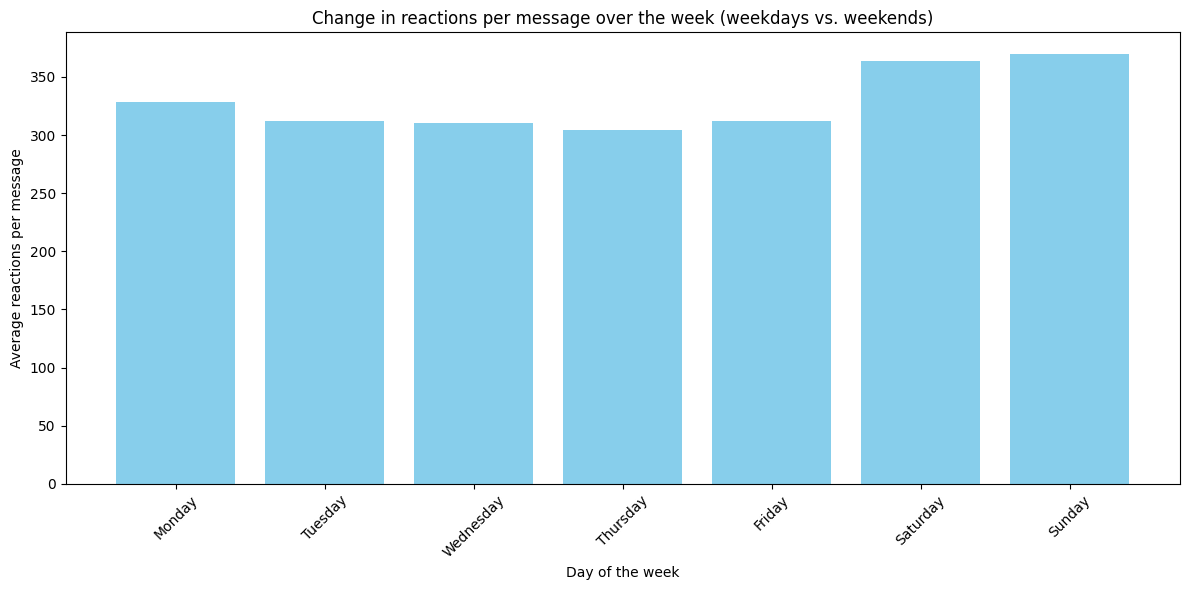

In [25]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['day_of_week'] = df['date'].dt.day_name()

reactions_per_day = df.groupby('day_of_week')['total_reactions_count'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
plt.bar(reactions_per_day.index, reactions_per_day.values, color='skyblue')
plt.xlabel('Day of the week')
plt.ylabel('Average reactions per message')
plt.title('Change in reactions per message over the week (weekdays vs. weekends)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 5 HOMEWORK PART:

### I did some changes in this file without saving last result, so I will list it there:

- (13) Changed percentage calculations (it was wrong), so chart changed too, it is correct now.
- "Check if spike exists", (2), (3), (4) - did chart wider
- (1) Added visualization
- Added answers to some questions (3, 4, 5, 7, 17)
- Added visualization (wordCloud) to (10, 18) question
- Added visualization to (11) question

## Adding sentiment to messages using https://github.com/dkulagin/kartaslov/blob/master/dataset/kartaslovsent

In [5]:
sentiment_dict = pd.read_csv('kartaslovsent.csv', delimiter=';')

sentiment_map = sentiment_dict.set_index('term')['value'].to_dict()

def calculate_sentiment(message):
    if pd.isnull(message):
        return 0
    words = nltk.word_tokenize(message)
    sentiment_scores = [sentiment_map[word.lower()] for word in words if word.lower() in sentiment_map]
    return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

df['sentiment_score'] = df['message'].apply(calculate_sentiment)
df.to_csv('df_with_sentiment.csv', index=False) #so I won't have to process this code again

In [2]:
dtype_dict = {
    'Unnamed: 0': 'int32',
    'id': 'str',
    'date': 'str',
    'views': 'float32',
    'reactions': 'str',
    'to_id': 'str', 
    'fwd_from': 'str',
    'message': 'str',
    'type': 'category', 
    'duration': 'float32',
    'dialog_id': 'str',
    'frw_from_title': 'str', 
    'frw_from_name': 'str',
    'msg_entity': 'str',
    'sentiment_score': 'float32'
}

chunk_size = 10000

chunks = pd.read_csv('./df_with_sentiment.csv', chunksize=chunk_size, dtype=dtype_dict)

df = pd.concat(chunks, ignore_index=True)

print(df.head())

   Unnamed: 0       id                       date   views  \
0           0  12602.0  2022-12-19 13:05:23+00:00  3645.0   
1           1  12601.0  2022-12-19 09:52:21+00:00  5831.0   
2           2  12600.0  2022-12-19 09:18:53+00:00  3944.0   
3           3  12599.0  2022-12-19 08:32:39+00:00  2970.0   
4           4  12598.0  2022-12-18 21:41:25+00:00  4993.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                reactions  \
0                                                                                                                           

## 22. How sentiment changes with channel popularity

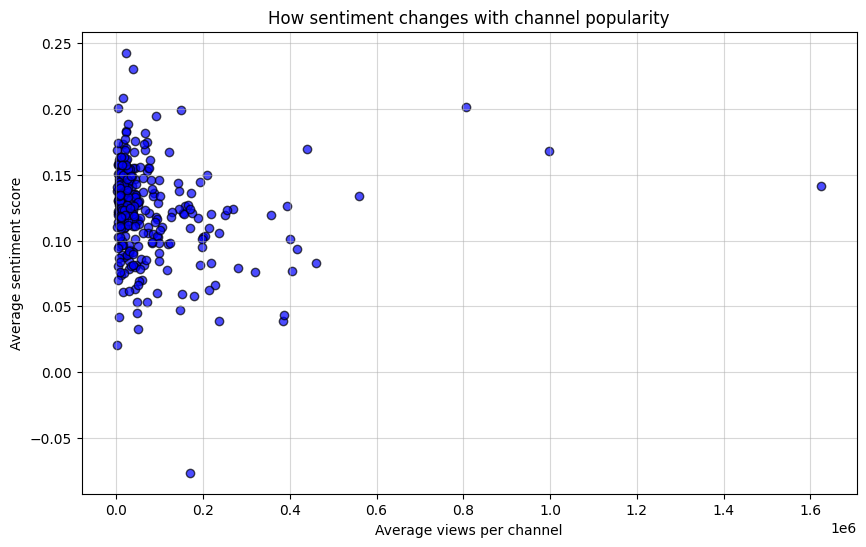

In [3]:
channel_analysis = df.groupby('dialog_id').agg({
    'views': 'mean',
    'sentiment_score': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(channel_analysis['views'], channel_analysis['sentiment_score'], alpha=0.7, color='blue', edgecolors='black')

plt.title('How sentiment changes with channel popularity')
plt.xlabel('Average views per channel')
plt.ylabel('Average sentiment score')
plt.grid(True, alpha=0.5)

plt.show()

## 23. Top 20 keywords in emotionally charged posts:

Top 20 keywords in emotionally charged posts:


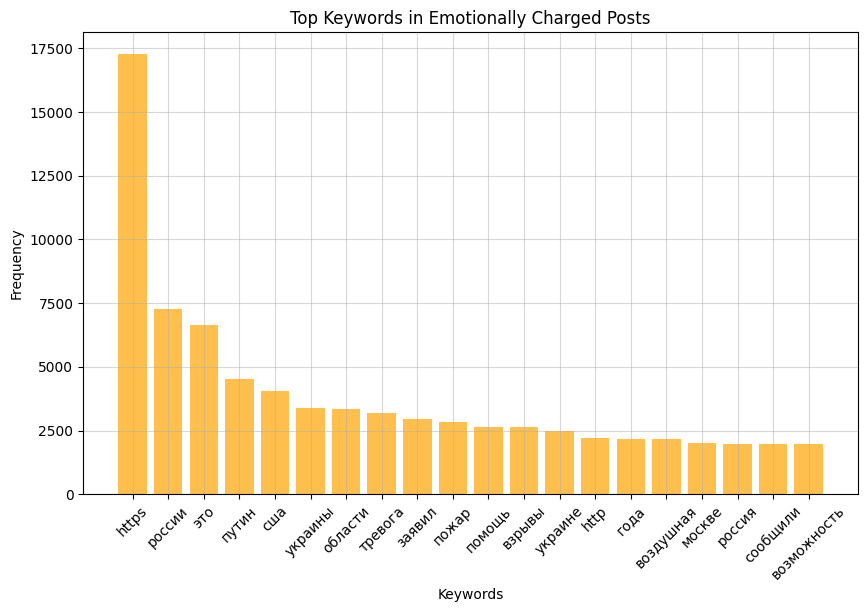

In [8]:
def is_valid_word(word):
    return (
        word.isalpha() and
        word not in stop_words and 
        len(word) > 2
    )

extreme_positive_threshold = 0.8
extreme_negative_threshold = -0.8
extreme_posts = df[(df['sentiment_score'] > extreme_positive_threshold) | (df['sentiment_score'] < extreme_negative_threshold)]

keywords = []
for message in extreme_posts['message'].dropna():
    words = nltk.word_tokenize(message)
    filtered_words = [word.lower() for word in words if is_valid_word(word.lower())]
    keywords.extend(filtered_words)

keyword_counts = Counter(keywords).most_common(20)

print("Top 20 keywords in emotionally charged posts:")

keywords, counts = zip(*keyword_counts)
plt.figure(figsize=(10, 6))
plt.bar(keywords, counts, color='orange', alpha=0.7)
plt.title("Top keywords in emotionally charged Posts")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)
plt.show()

## 24. How does the positive or negative sentiment of messages mentioning "Украина" affect the average number of reactions those messages receive?

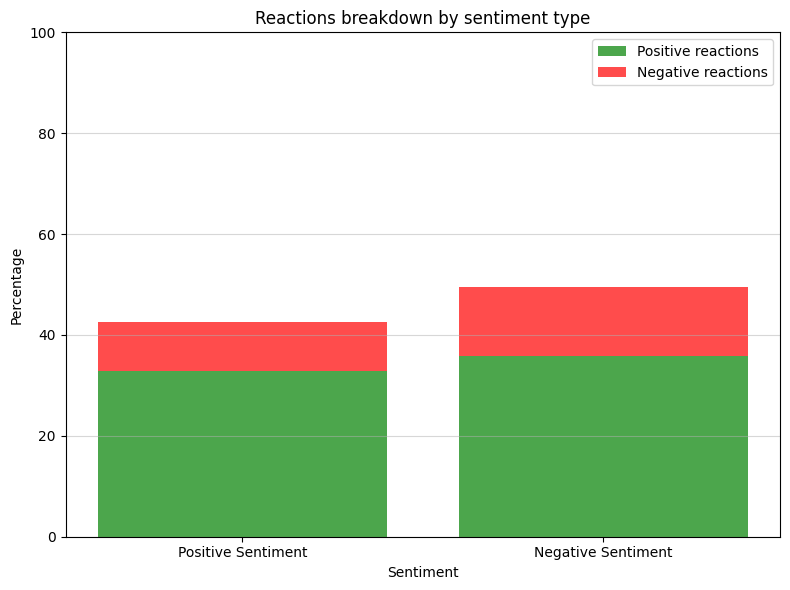

In [15]:
ukraine_messages = df[df['message'].str.contains(r'\bУкраина\b', case=False, na=False)].copy()

positive_reactions_list = ['👍', '🔥', '👏', '😁', '❤️', '💯', '🌚', '❤', '🥰', '🎉']
negative_reactions_list = ['👎', '😢', '🤮', '🤡', '🤬', '💩', '😱']


# function to calculate percentages of reactions (we already have columns "positive_reactions_count" / "negative_reactions_count")
def calculate_percentages(reactions):
    if pd.isnull(reactions):
        return 0, 0
    reactions_list = reactions.split(',')
    total = len(reactions_list)
    if total == 0:
        return 0, 0
    pos = sum(reaction in positive_reactions_list for reaction in reactions_list)
    neg = sum(reaction in negative_reactions_list for reaction in reactions_list)
    return (pos / total) * 100, (neg / total) * 100

ukraine_messages['positive_reactions_percentage'] = ukraine_messages.apply(
    lambda row: (row['positive_reactions_count'] / row['total_reactions_count']) * 100
    if row['total_reactions_count'] > 0 else 0, axis=1
)
ukraine_messages['negative_reactions_percentage'] = ukraine_messages.apply(
    lambda row: (row['negative_reactions_count'] / row['total_reactions_count']) * 100
    if row['total_reactions_count'] > 0 else 0, axis=1
)

positive_sentiment = ukraine_messages[ukraine_messages['sentiment_score'] > 0]
negative_sentiment = ukraine_messages[ukraine_messages['sentiment_score'] < 0]

positive_avg_pos = positive_sentiment['positive_reactions_percentage'].mean()
positive_avg_neg = positive_sentiment['negative_reactions_percentage'].mean()

negative_avg_pos = negative_sentiment['positive_reactions_percentage'].mean()
negative_avg_neg = negative_sentiment['negative_reactions_percentage'].mean()

labels = ['Positive Sentiment', 'Negative Sentiment']
positive_reactions = [positive_avg_pos, negative_avg_pos]
negative_reactions = [positive_avg_neg, negative_avg_neg]

x = range(len(labels))

plt.figure(figsize=(8, 6))
plt.bar(x, positive_reactions, label='Positive reactions', color='green', alpha=0.7)
plt.bar(x, negative_reactions, bottom=positive_reactions, label='Negative reactions', color='red', alpha=0.7)

plt.xticks(x, labels)
plt.title("Reactions breakdown by sentiment type")
plt.ylabel("Percentage")
plt.xlabel("Sentiment")
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

## 25. Which Western countries are most frequently mentioned in messages, and how has their mention frequency changed over time?

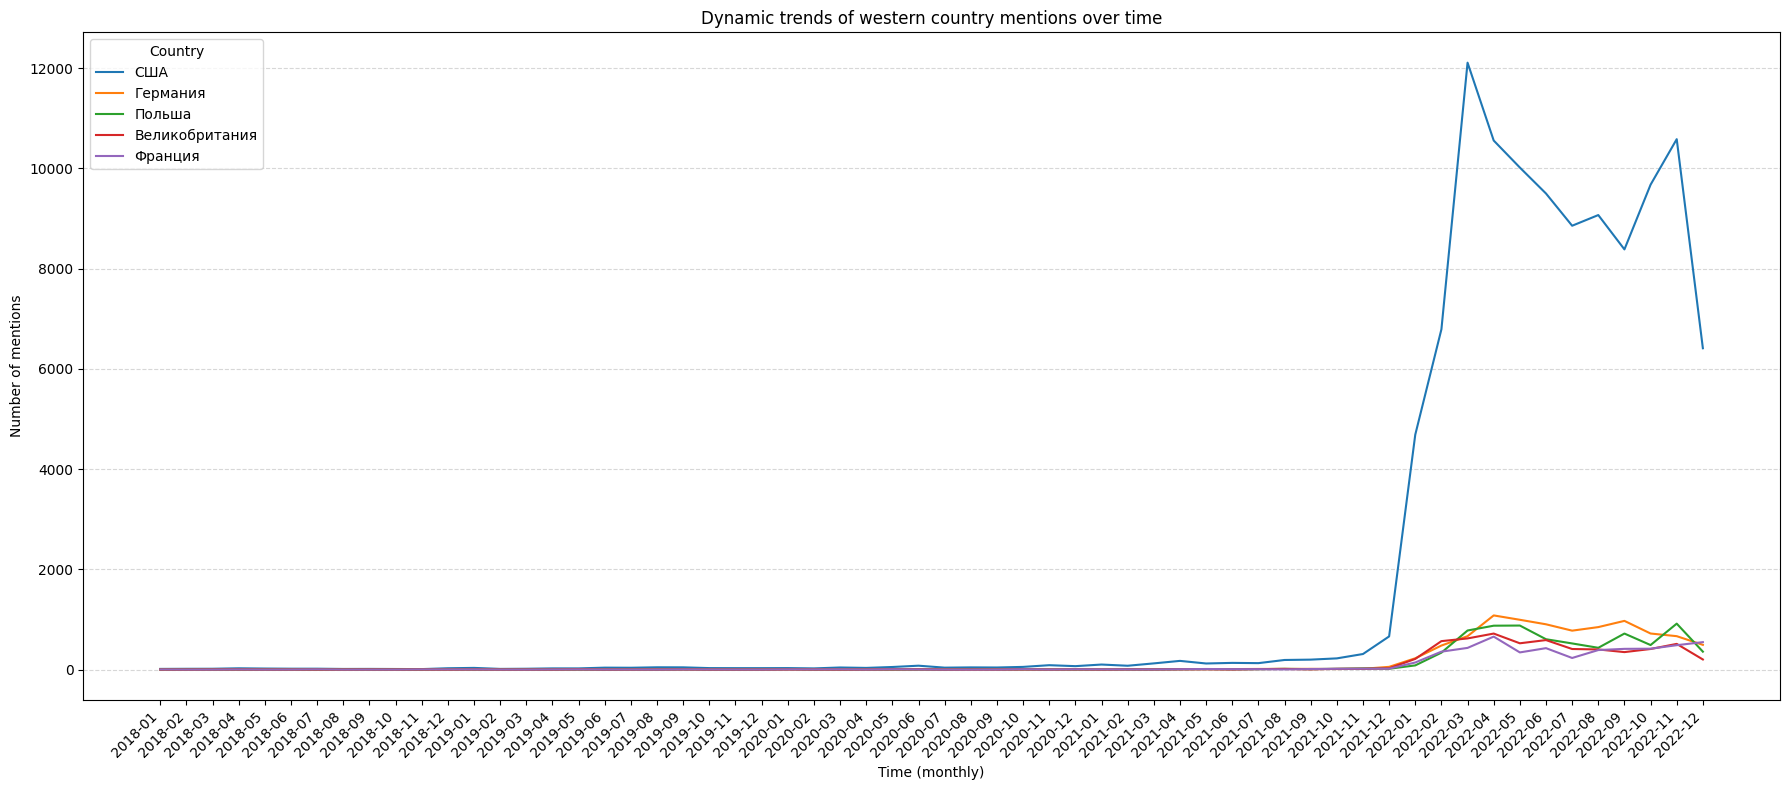

In [21]:
western_countries = [
    'Андорра', 'Австралия', 'Австрия', 'Бельгия', 'Канада', 'Хорватия', 'Чехия',
    'Дания', 'Эстония', 'Финляндия', 'Франция', 'Германия', 'Венгрия', 'Исландия',
    'Ирландия', 'Италия', 'Латвия', 'Лихтенштейн', 'Литва', 'Люксембург', 'Монако',
    'Нидерланды', 'Новая Зеландия', 'Норвегия', 'Португалия', 'Польша', 'Сан-Марино',
    'Словакия', 'Словения', 'Испания', 'Швеция', 'Швейцария', 'Великобритания',
    'США', 'Ватикан'
]

def mentions_western_country(message):
    if pd.isnull(message):
        return []
    mentioned_countries = [country for country in western_countries if country in message]
    return mentioned_countries

df['western_mentions'] = df['message'].apply(mentions_western_country)
df['has_western_mentions'] = df['western_mentions'].apply(lambda x: len(x) > 0)

df_western_mentions = df[df['has_western_mentions']].copy()

df['positive_reactions_percentage'] = (df['positive_reactions_count'] / df['total_reactions_count']) * 100
df['negative_reactions_percentage'] = (df['negative_reactions_count'] / df['total_reactions_count']) * 100

channel_analysis = df_western_mentions.groupby('dialog_id').agg({
    'western_mentions': 'count',
    'views': 'mean',
    'reactions': 'count',
    'positive_reactions_count': 'sum',
    'negative_reactions_count': 'sum',
    'positive_reactions_percentage': 'mean',
    'negative_reactions_percentage': 'mean'
}).sort_values(by='western_mentions', ascending=False)

df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

df_filtered = df[df['date'] >= pd.Timestamp('2018-01-01')]

time_mentions = pd.DataFrame()

full_period_range = pd.period_range(start='2018-01', end=df_filtered['date'].max().to_period('M'), freq='M')

for country in western_countries:
    mentions = (
        df_filtered[df_filtered['message'].str.contains(country, na=False)]
        .groupby(df_filtered['date'].dt.to_period('M'))
        .size()
    )
    time_mentions[country] = mentions.reindex(full_period_range, fill_value=0)

country_mentions = time_mentions.sum().sort_values(ascending=False)

top_countries = country_mentions.head(5).index

plt.figure(figsize=(18, 8))

for country in top_countries:
    plt.plot(
        time_mentions.index.astype(str),
        time_mentions[country],
        label=country
    )

plt.xlabel('Time (monthly)')
plt.ylabel('Number of mentions')
plt.title('Dynamic trends of western country mentions over time')
plt.legend(title='Country')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()